# Welcome to the Future :)
Notebook by Rayce Stipanovich

This is a Python Jupyter Notebook designed to output low-poly .gltf files for use in 3D content or web stuff.

### Relies on:
- Python v3, Jupyter Notebooks
- NVIDIA CUDA v11.7 (or your CPU if you're a noob)
- OpenAI's Point-E Beta
- Blender w/ .gltf Exporter extension

### Installation and First-Time-Setup
1. Make sure you have [Python 3 installed.](https://www.python.org/downloads/)
2. Install the the [NVIDIA CUDA drivers v11.7](https://developer.nvidia.com/cuda-11-7-0-download-archive)
3. Install the [Python VSCode Extension](https://marketplace.visualstudio.com/items?itemName=ms-python.python)
4. Install the [Jupyter VSCode Extension](https://marketplace.visualstudio.com/items?itemName=ms-toolsai.jupyter)
5. Follow the rest of the instructions below...

___

## First-Time Setup (Continued)
Run the pip installer to install the [CUDA 11.7 version of PyTorch](https://pytorch.org/get-started/locally/) along with the other dependanceis Point-E Needs.

In [1]:
# install dependencies
%pip install -e .

Obtaining file:///C:/Users/Rayce/poiint_e/point-e
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Cloning https://github.com/openai/CLIP.git to c:\users\rayce\appdata\local\temp\pip-install-k1ygfqia\clip_ab8c34ad8c56427286f086d116b4a680
  Resolved https://github.com/openai/CLIP.git to commit d50d76daa670286dd6cacf3bcd80b5e4823fc8e1
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Attempting uninstall: point-e
    Found existing installation: point-e 0.0.0
    Uninstalling point-e-0.0.0:
      Successfully uninstalled point-e-0.0.0
  Running setup.py develop for point-e
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\Rayce\AppData\Local\Temp\pip-install-k1ygfqia\clip_ab8c34ad8c56427286f086d116b4a680'


In [2]:
# install pytorch w/ cuda 11.7
%pip uninstall torch -y
%pip install torch --force-reinstall --extra-index-url https://download.pytorch.org/whl/cu117

Note: you may need to restart the kernel to use updated packages.Found existing installation: torch 1.13.1+cu117
Uninstalling torch-1.13.1+cu117:
  Successfully uninstalled torch-1.13.1+cu117



Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117
  Using cached https://download.pytorch.org/whl/cu117/torch-1.13.1%2Bcu117-cp310-cp310-win_amd64.whl (2255.4 MB)
  Using cached typing_extensions-4.4.0-py3-none-any.whl (26 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.4.0
    Uninstalling typing_extensions-4.4.0:
      Successfully uninstalled typing_extensions-4.4.0
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


#### STOP!  
Restart the Python Kernel in Jyputer to enable everyting we just setup.  You won't need to do anything above here in the future hpefully lol.

___

# START HERE EVERY TIME YOU LAUNCH
Run these to import the dependances andmake sure we can use the GPU!

In [ ]:
# Import PyTorch and Point-E Libs...
from PIL import Image
import random
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.pc_to_mesh import marching_cubes_mesh
from point_e.util.plotting import plot_point_cloud
from point_e.util.point_cloud import PointCloud

### STOP
Sanity check that CUDA is working.... otherwise this will take forever...
If you see CPU, then HMU to help debug.  You should see CUDA here!

In [2]:
# Check if GPU is available
if torch.cuda.is_available():
   print('Using NVIDIA Cuda')
else:
   print('Using CPU')
   
print("PyTorch Version: "+torch.__version__)

Using NVIDIA Cuda
PyTorch Version: 1.13.1+cu117


___

### One-Time-Setup after Launch and CUDA is OK.
Import the ML Models into the GPU and initialize the point cloud.  Run these once after you get torch with CUDA up and running.

Here is where we also say what version of Blender we would like to use to convet the .ply model intermediates into .gltf files.

In [3]:
# Setup Blender Converter
blender_version = 3.0
blender_path = "C:\Program Files\Blender Foundation\Blender "+str(blender_version)+"\\blender.exe"

In [10]:
# Preapre the models on the GPU...
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M-textvec'
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('creating SDF model...')
sdf_model = model_from_config(MODEL_CONFIGS['sdf'], device)
sdf_model.eval()

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

print('downloading SDF checkpoint...')
sdf_model.load_state_dict(load_checkpoint('sdf', device))

creating base model...
creating upsample model...
creating SDF model...
downloading base checkpoint...
downloading upsampler checkpoint...
downloading SDF checkpoint...


<All keys matched successfully>

In [11]:
# Initialize the point cloud sampler
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 0.0],
    model_kwargs_key_filter=('texts', ''), # Do not condition the upsampler at all
)
print("Point Cloud Sampler Initialized")

Point Cloud Sampler Initialized


___

### THE FUN PART!!!
Keep Re-Running this code afterwards to generate new models based on your prompt.  Remember to re-run the prompt chunk below toa ctually update the prompt on the model!

In [12]:
# Set a prompt to condition on.
prompt = 'apple tree'

130it [00:27,  4.76it/s]


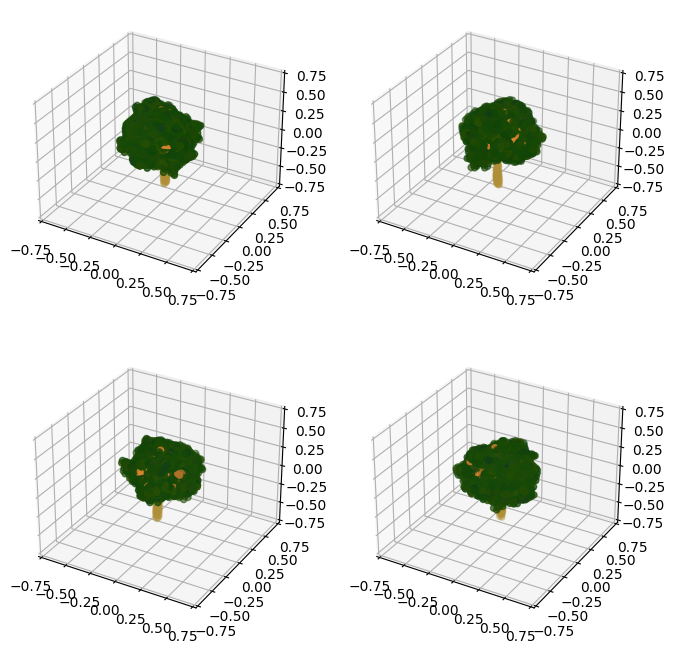

In [13]:
# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(texts=[prompt]))):
    samples = x
    
# Generate the point cloud and plot it.
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=2, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

If the Above output looks good, run the next two to output a .gltf in the outputs folder.

In [14]:
# Produce a mesh (with vertex colors) from the point cloud. and write it to a PLY file.
mesh = marching_cubes_mesh(
    pc=pc,
    model=sdf_model,
    batch_size=4096,
    grid_size=32, # increase to 128 for resolution used in evals
    progress=True,
)

newP = prompt.replace(" ", "_") + "_" + str(random.randint(1, 1000000))
fileName = 'intermediates/'+newP+".ply"

# Write the mesh to a PLY file to import into some other program.
with open(fileName, 'wb') as f:
    mesh.write_ply(f)
    
print("Generated mesh saved to: "+fileName)

100%|██████████| 8/8 [00:00<00:00, 249.93it/s]


Generated mesh saved to: intermediates/apple_tree_646573.ply


In [24]:
# Convert the .ply file to embedded .gltf file using Blender
!"$blender_path" -b -P 2gltf2.py -- "$fileName"
outputName = fileName.replace(".ply",".gltf").replace("intermediates/","outputs/")
print("\n============================================\n\n   .gltf file exported successfully! :)")
print("\n\n at the path: " + outputName)
print("\n\n============================================")

Blender 3.0.0 (hash f1cca3055776 built 2021-12-03 00:44:02)
Read prefs: C:\Users\Rayce\AppData\Roaming\Blender Foundation\Blender\3.0\config\userpref.blend
Converting: 'intermediates/apple_tree_646573.ply'

Successfully imported 'intermediates/apple_tree_646573.ply' in 0.120 sec
Writing: 'c:\Users\Rayce\poiint_e\point-e/outputs/apple_tree_646573.gltf'
'C:\Program Files\Blender Foundation\Blender 3.0\3.0\python\lib\site-packages\extern_draco.dll' exists, draco mesh compression is available
00:21:10 | INFO: Starting glTF 2.0 export
00:21:10 | INFO: Extracting primitive: apple_tree_646573
00:21:10 | INFO: Primitives created: 1
00:21:10 | INFO: Finished glTF 2.0 export in 0.021999597549438477 s


Blender quit


   .gltf file exported successfully! :)


 at the path: outputs/apple_tree_646573.gltf


